In [3]:

# from polytropic_stars.EOSPath import EOSPath
from EOSGenerator import EOSGenerator
import matplotlib.pyplot as plt
import random
from CRUST import CRUST
import numpy as np
from scipy.integrate import solve_ivp
import random
import csv
import os 
from EOS import EOS
# TOV right-hand side equations

# TOV right-hand side equations
def tov_rhs(r, z, eos_object, P_saturation):
    M, P = z

    if P <= 0:
        return [0, 0]

    if P > P_saturation:
        epsilon = eos_object.energy_density_from_pressure(P)

    elif 0.184 <= P <= P_saturation:
        e = EOS(P)
        epsilon = e.HLPS_2()

    else:
        crust = CRUST(P)
        epsilon = crust.equation()

    dM_dr = 11.2e-6 * r**2 * epsilon
    dP_dr = -1.474 * (epsilon * M / r**2) * (1 + P / epsilon) * (1 + 11.2e-6 * r**3 * P / M) * (1 - 2.948 * M / r)**(-1)

    return [dM_dr, dP_dr]


# Stopping event when pressure becomes tiny
def stop_when_pressure_small(r, y):
    return y[1] - 1e-10  # Stop when P ~ 0
stop_when_pressure_small.terminal = True
stop_when_pressure_small.direction = -1

# Solve a single TOV star
def solve_star(P_central, eos_object):
    
    z0 = [1e-12, P_central]  # Initial [M, P]
    r_span = (1e-9, 2e6)     # Integrate from tiny radius up to big radius
    sol = solve_ivp(lambda r, z: tov_rhs(r, z, eos_object, 1.722),
                    r_span, 
                    z0,
                    method='RK45',
                    atol=1e-10,
                    rtol=1e-8,
                    events=[stop_when_pressure_small],
                    max_step=0.1)
    return sol

# Process one EOS model
def process_model(model_name, eos_object, initial_pressures):
    results = []

    for i, P_center in enumerate(initial_pressures):
        sol = solve_star(P_center, eos_object)

        if sol.status == 1:  # event triggered (good convergence)
            R_star = sol.t_events[0][0]  # surface radius
            M_star = sol.y_events[0][0][0]  # final mass
            results.append((M_star, R_star, P_center))
            print(f"Model:{model_name} | Mass:{M_star:.4f} | Radius:{R_star:.4f} | Pc={P_center:.2f}")
        else:
            print(f"Warning: Model {model_name} Pc={P_center:.2f} did not converge.")

    return model_name, results

# MAIN EXECUTION
if __name__ == "__main__":
    # Create folder for results
    os.makedirs('TOV_results', exist_ok=True)

    # Generate EOS models
    p_sat = 1.722  # MeV/fm³
    e = EOS(p_sat)
    initial_rho = e.HLPS_2()  # fm⁻³
    segments = 4
    gamma_options = [1, 5]

    generator = EOSGenerator(p_saturation=p_sat, initial_density=initial_rho, segments=segments, gamma_options=gamma_options)
    generator.generate()
    eos_models = generator.get_models()

    # Define central pressures
    ic1 = np.arange(1.5, 5, 0.1)
    ic2 = np.arange(5, 1200, 1)
    initial_pressures = np.concatenate((ic1, ic2), axis=None)

    # Solve for all EOS models
    for eos_model in eos_models:
        model_name = eos_model.name
        eos_object = eos_model

        model_name, model_results = process_model(model_name, eos_object, initial_pressures)

        # Save results
    with open(f"TOV_results/{model_name}_TOV.csv", "w", newline="") as f:
        write_obj = csv.writer(f)
        write_obj.writerow(["Mass", "Radius", "Pressure", "Type"])
        for m, r, p in model_results:
            write_obj.writerow([m, r, p, 0])

Model:EOS_0 | Mass:0.7217 | Radius:2375.8676 | Pc=1.50
Model:EOS_0 | Mass:0.2124 | Radius:2262.3662 | Pc=1.60
Model:EOS_0 | Mass:0.0595 | Radius:142.0360 | Pc=1.70
Model:EOS_0 | Mass:0.0620 | Radius:66.4639 | Pc=1.80
Model:EOS_0 | Mass:0.0651 | Radius:44.9093 | Pc=1.90
Model:EOS_0 | Mass:0.0682 | Radius:34.8975 | Pc=2.00
Model:EOS_0 | Mass:0.0713 | Radius:29.4048 | Pc=2.10
Model:EOS_0 | Mass:0.0740 | Radius:26.1162 | Pc=2.20
Model:EOS_0 | Mass:0.0764 | Radius:23.9282 | Pc=2.30
Model:EOS_0 | Mass:0.0785 | Radius:22.3435 | Pc=2.40
Model:EOS_0 | Mass:0.0805 | Radius:21.1523 | Pc=2.50
Model:EOS_0 | Mass:0.0822 | Radius:20.1899 | Pc=2.60
Model:EOS_0 | Mass:0.0838 | Radius:19.4747 | Pc=2.70
Model:EOS_0 | Mass:0.0852 | Radius:18.8527 | Pc=2.80
Model:EOS_0 | Mass:0.0865 | Radius:18.3386 | Pc=2.90
Model:EOS_0 | Mass:0.0877 | Radius:17.8936 | Pc=3.00
Model:EOS_0 | Mass:0.0887 | Radius:17.5129 | Pc=3.10
Model:EOS_0 | Mass:0.0897 | Radius:17.1765 | Pc=3.20
Model:EOS_0 | Mass:0.0906 | Radius:16.891

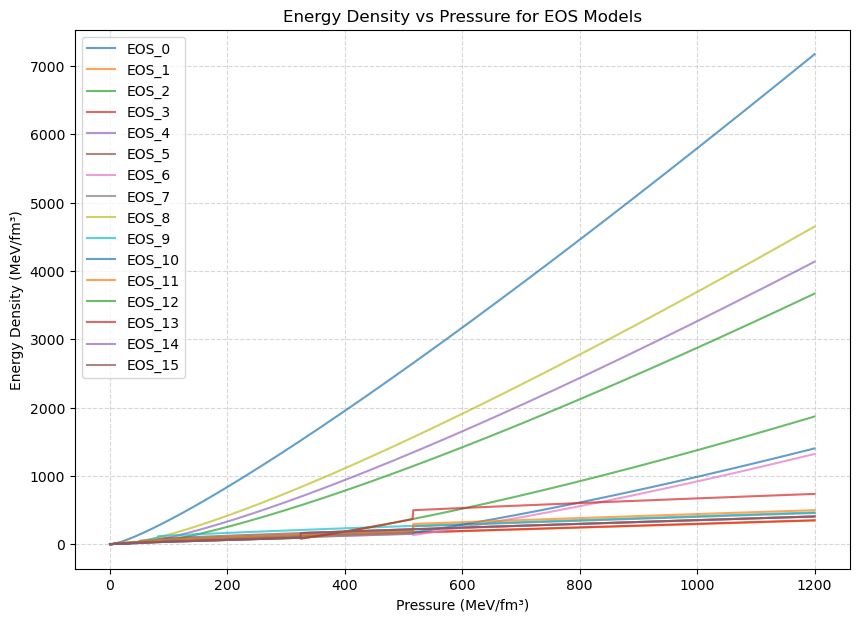

In [ ]:
plt.figure(figsize=(10, 7))

# Plot HLPS_2 EOS
plt.plot(p, e1, label="HLPS_2", linewidth=2)

# Plot energy_density_from_pressure for each model
for model in eos_models:
    energy_density = [model.energy_density_from_pressure(pressure) for pressure in p]
    plt.plot(p, energy_density, label=model.name, alpha=0.7)

plt.xlabel("Pressure (MeV/fm³)")
plt.ylabel("Energy Density (MeV/fm³)")
plt.title("Energy Density vs Pressure for EOS Models")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()


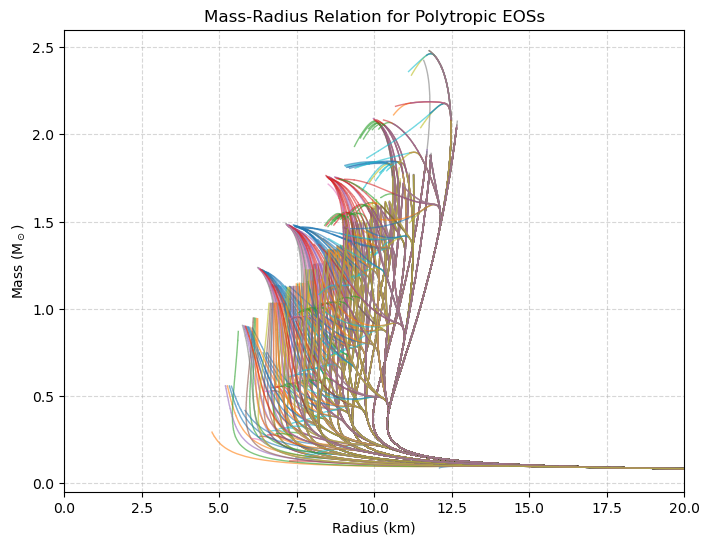

In [1]:
import matplotlib.pyplot as plt
import csv
import glob

files = glob.glob("polytropic_main/TOV_results/*TOV.csv")

plt.figure(figsize=(8,6))
for file in files:
    masses, radii = [], []
    with open(file, 'r') as f:
        reader = csv.DictReader(f)
        for row in reader:
            mass_km = float(row['Mass'])
            radius_km = float(row['Radius'])
            mass_Msun = mass_km 
            masses.append(mass_Msun)
            radii.append(radius_km)
    plt.plot(radii, masses, alpha=0.6, lw=1)

plt.xlabel("Radius (km)")
plt.ylabel("Mass (M$_\odot$)")
plt.title("Mass-Radius Relation for Polytropic EOSs")
plt.grid(True, which="both", ls="--", alpha=0.5)
plt.xlim(0, 20)
plt.show()


<>:21: SyntaxWarning: invalid escape sequence '\o'
<>:21: SyntaxWarning: invalid escape sequence '\o'
C:\Users\vasil\AppData\Local\Temp\ipykernel_14748\475514301.py:21: SyntaxWarning: invalid escape sequence '\o'
  plt.ylabel("Mass (M$_\odot$)")


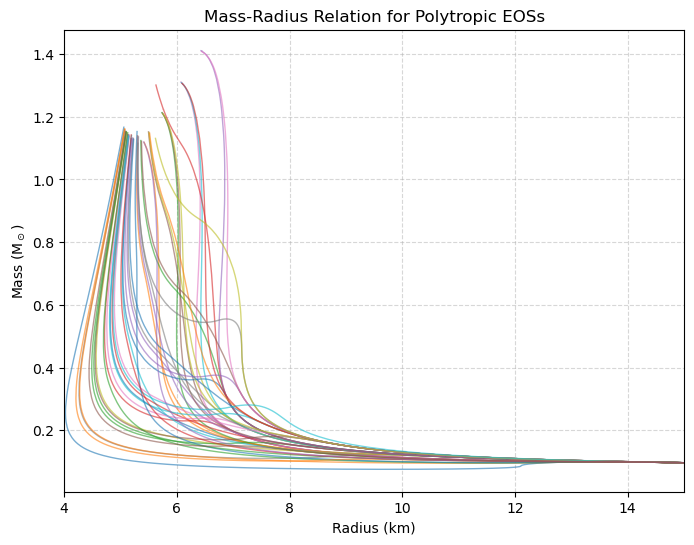

In [16]:
import matplotlib.pyplot as plt
import csv
import glob

files = glob.glob("polytropic_main/TOV_results_1_2_3_4/*TOV.csv")

plt.figure(figsize=(8,6))
for file in files:
    masses, radii = [], []
    with open(file, 'r') as f:
        reader = csv.DictReader(f)
        for row in reader:
            mass_km = float(row['Mass'])
            radius_km = float(row['Radius'])
            mass_Msun = mass_km 
            masses.append(mass_Msun)
            radii.append(radius_km)
    plt.plot(radii, masses, alpha=0.6, lw=1)

plt.xlabel("Radius (km)")
plt.ylabel("Mass (M$_\odot$)")
plt.title("Mass-Radius Relation for Polytropic EOSs")
plt.grid(True, which="both", ls="--", alpha=0.5)
plt.xlim(4, 15)
plt.show()


<>:48: SyntaxWarning: invalid escape sequence '\g'
<>:48: SyntaxWarning: invalid escape sequence '\g'
C:\Users\vasil\AppData\Local\Temp\ipykernel_8808\3911374938.py:48: SyntaxWarning: invalid escape sequence '\g'
  label = f"$\gamma_1$={gamma_1}" if gamma_1 not in plotted_labels else None


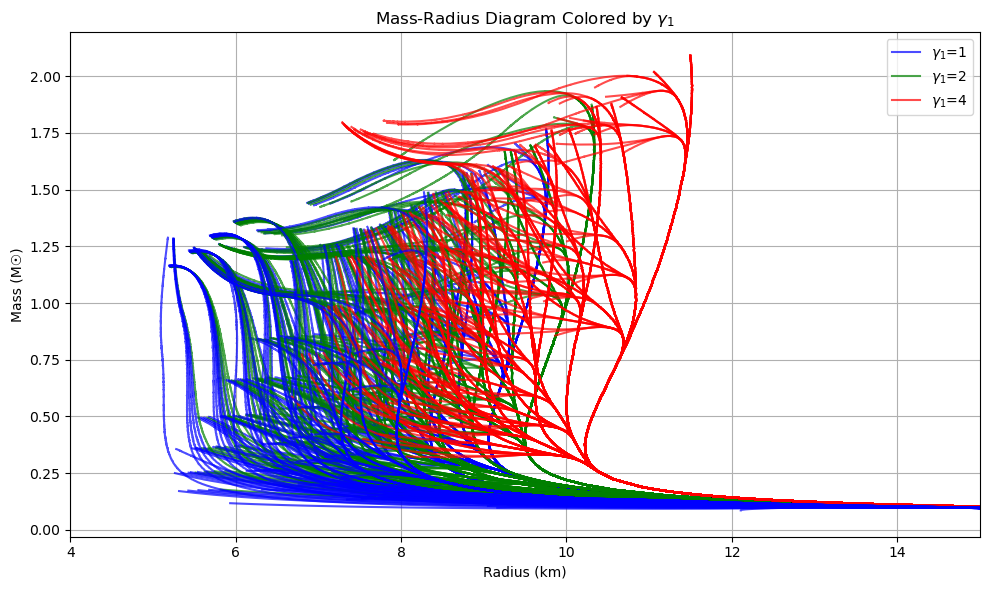

In [ ]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

# ---- Configuration ----

# Define gamma_1 values and corresponding colors
gamma_colors = {
    1: 'blue',
    2: 'green',
    4: 'red'
}

# Path to TOV result CSVs
results_folder = "TOV_results_1_2_3_4"

# Extract gamma_1 values from filenames (you can also use a mapping file if needed)
def get_gamma1_from_filename(filename):
    # Assume filename pattern: EOS_<index>_TOV.csv
    # You must manually map index to gamma_1 or hardcode it if you don't recompute
    index = int(filename.split("_")[1])
    # This mapping must match how your models were generated in the original script
    gamma_options = [1, 2,  4]
    segments = 6
    from itertools import product
    all_gamma_paths = list(product(gamma_options, repeat=segments))
    gamma_1 = all_gamma_paths[index - 1][0]  # Subtract 1 because EOS_1 is index 0
    return gamma_1

# ---- Plotting ----

plt.figure(figsize=(10, 6))

plotted_labels = set()

for filepath in sorted(glob.glob("polytropic_main/TOV_results_1_2_3_4/*TOV.csv")):
    filename = os.path.basename(filepath)
    gamma_1 = get_gamma1_from_filename(filename)
    color = gamma_colors.get(gamma_1, 'black')

    data = np.genfromtxt(filepath, delimiter=',', skip_header=1)
    if data.ndim != 2 or data.shape[0] == 0:
        continue
    M_vals = data[:, 0]
    R_vals = data[:, 1]

    label = f"$\gamma_1$={gamma_1}" if gamma_1 not in plotted_labels else None
    if label:
        plotted_labels.add(gamma_1)
    
    # if gamma_1 == 4:
    plt.plot(R_vals, M_vals, color=color, alpha=0.7, label=label)

# ---- Labels and Legend ----

plt.xlabel("Radius (km)")
plt.ylabel("Mass (M☉)")
plt.title("Mass-Radius Diagram Colored by $\\gamma_1$")
plt.grid(True)
plt.legend()
plt.tight_layout()
# plt.savefig(os.path.join(results_folder, "MR_diagram_by_gamma1.png"))
plt.xlim(4,15)
plt.show()


In [4]:
import pandas as pd 
# List all CSV files in the TOV_results directory
files = glob.glob("polytropic_main/TOV_results/*TOV.csv")  
maxs = []
for file in files:
    # Read the CSV file into a DataFrame
    df = pd.read_csv(file)
    maxs.append(df['Pressure'].max())
# Find the maximum pressure across all files
max_pressure = max(maxs)
print(f"Maximum pressure across all EOS models: {max_pressure:.2f} MeV/fm³")
    

Maximum pressure across all EOS models: 2000.00 MeV/fm³


In [5]:
print("Maximum pressure across all EOS models:", maxs)

Maximum pressure across all EOS models: [193.0, 1516.0, 363.0, 379.0, 1344.0, 306.0, 252.0, 252.0, 256.0, 98.0, 2000.0, 774.0, 429.0, 193.0, 1516.0, 362.0, 379.0, 1330.0, 303.0, 193.0, 1516.0, 648.0, 367.0, 379.0, 1358.0, 308.0, 254.0, 255.0, 256.0, 379.0, 1403.0, 317.0, 2000.0, 742.0, 933.0, 265.0, 212.0, 213.0, 215.0, 193.0, 1516.0, 372.0, 379.0, 648.0, 1381.0, 313.0, 258.0, 258.0, 261.0, 379.0, 1430.0, 322.0, 742.0, 951.0, 2000.0, 270.0, 216.0, 216.0, 224.0, 178.0, 178.0, 179.0, 178.0, 179.0, 179.0, 2000.0, 179.0, 179.0, 193.0, 98.0, 774.0, 433.0, 193.0, 1516.0, 365.0, 379.0, 2000.0, 1341.0, 306.0, 193.0, 1516.0, 369.0, 379.0, 1370.0, 310.0, 256.0, 256.0, 2000.0, 256.0, 379.0, 1414.0, 317.0, 742.0, 941.0, 265.0, 214.0, 214.0, 215.0, 2000.0, 193.0, 1516.0, 375.0, 379.0, 1395.0, 315.0, 260.0, 260.0, 261.0, 379.0, 2000.0, 2000.0, 1443.0, 324.0, 742.0, 961.0, 270.0, 218.0, 218.0, 224.0, 180.0, 180.0, 2000.0, 183.0, 180.0, 181.0, 188.0, 180.0, 182.0, 193.0, 379.0, 1489.0, 331.0, 2000.0, 

In [6]:
max(maxs)

2000.0

In [42]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import product
from scipy.integrate import solve_ivp
import csv
import os
from itertools import product
from concurrent.futures import ProcessPoolExecutor, as_completed
from CRUST import CRUST
# Constants
r_sat = 2.7e14  # g/cm^3
c = 2.998e8  # m/s
MeV_to_J = 1.60218e-13  # 1 MeV in Joules


# Conversion function
def conv_to_MeV(value):
    result = value * 1e3  # to kg/m^3
    result = result * c ** 2  # to J/m^3
    result = result / MeV_to_J  # to MeV/m^3
    result = result * 1e-45  # to MeV/fm^3
    return result


# HLPS_2 function
def HLPS_2(P):
    return 172.858 * (1 - np.exp(-P / 22.8644)) + 2777.75 * (1 - np.exp(-P / 1909.97)) + 161.553


# EOSPath class
class EOSPath:
    def __init__(self, P0, E0, segment_densities, gammas, name="EOS"):
        self.segment_densities = np.array(segment_densities)
        self.gammas = np.array(gammas)
        self.P0 = P0
        self.E0 = E0
        self.name = name
        self.Pi = []
        self.Ei = []
        self.K_list = []
        self.linear_start = None
        self.linear_eps = None

    def calculate_K(self, P, rho, gamma):
        return P / rho ** gamma

    def calculate_P(self, rho, K, gamma):
        return K * rho ** gamma

    def calculate_E(self, P, Ki, gamma, rho_i, P_i, E_i):
        if gamma == 1:
            return (E_i / rho_i) * P / Ki + np.log(1 / rho_i) * P - P * np.log(Ki / P)
        else:
            return (E_i / rho_i - P_i / (rho_i * (gamma - 1))) * (P / Ki) ** (1 / gamma) + P / (gamma - 1)

    def dE_dP(self, P, Ki, gamma, rho_i, P_i, E_i):
        if gamma == 1:
            return E_i / (rho_i * Ki) + np.log(1 / rho_i) + 1 - np.log(Ki / P)
        else:
            return (1 / (Ki * gamma)) * (E_i / rho_i - P_i / (rho_i * (gamma - 1))) * (P / Ki) ** (1 / gamma - 1) + 1 / (gamma - 1)

    def EOS_Linear(self, P, P_transition, E_transition):
        
        return E_transition + (P - P_transition)
    
    def calculate_parameters(self):
        # Initialize storage lists
        Pi_vals = [self.P0]
        Ei_vals = [self.E0]
        Ki_vals = []

        n = len(self.gammas)

        # Calculate Pi, Ei, Ki arrays for each segment
        for i in range(n):
            gamma = self.gammas[i]
            rho_i = self.segment_densities[i]
            rho_next = self.segment_densities[i + 1]

            K_i = self.calculate_K(Pi_vals[i], rho_i, gamma)
            Ki_vals.append(K_i)

            P_next = self.calculate_P(rho_next, K_i, gamma)
            Ei_next = self.calculate_E(P_next, K_i, gamma, rho_i, Pi_vals[i], Ei_vals[i])

            Pi_vals.append(P_next)
            Ei_vals.append(Ei_next)

        # Fine pressure sampling for slope checking
        P_range = np.linspace(Pi_vals[0], Pi_vals[-1], 10_000)
        P_tr = None
        E_tr = None

        # Function to compute slope dE/dP for piecewise polytropic EOS at arbitrary P
        def slope_at_P(P):
            # Find which segment P belongs to
            for i in range(len(Pi_vals) - 1):
                if Pi_vals[i] <= P <= Pi_vals[i + 1]:
                    return self.dE_dP(P, Ki_vals[i], self.gammas[i], self.segment_densities[i], Pi_vals[i], Ei_vals[i])
            # If beyond known segments, assume linear EOS slope = 1
            if self.linear_start and P > self.linear_start:
                return 1
            return 1  # fallback

        # Find the first pressure where slope < 1 (causality violation)
        for P in P_range:
            slope = slope_at_P(P)
            if slope < 1:
                P_tr = P
                # Calculate corresponding energy at transition
                for i in range(len(Pi_vals) - 1):
                    if Pi_vals[i] <= P_tr <= Pi_vals[i + 1]:
                        E_tr = self.calculate_E(P_tr, Ki_vals[i], self.gammas[i], self.segment_densities[i], Pi_vals[i], Ei_vals[i])
                        break
                # Truncate lists at transition
                for idx, P_bound in enumerate(Pi_vals):
                    if P_bound >= P_tr:
                        Pi_vals = Pi_vals[:idx + 1]
                        Ei_vals = Ei_vals[:idx + 1]
                        Pi_vals[-1] = P_tr
                        Ei_vals[-1] = E_tr
                        break
                break

        # Save results to the object
        self.Pi = Pi_vals
        self.Ei = Ei_vals
        self.K_list = Ki_vals
        self.linear_start = P_tr
        self.linear_eps = E_tr

    def get_energy_from_pressure(self, P):
        for i in range(len(self.Pi) - 1):
            if self.Pi[i] <= P <= self.Pi[i + 1]:
                return self.calculate_E(P, self.K_list[i], self.gammas[i], self.segment_densities[i], self.Pi[i], self.Ei[i])
        if P > self.Pi[-1]:
            if self.linear_start is None or self.linear_eps is None:
                # fallback if linear start/eps not set
                return self.Ei[-1]  # or some other reasonable fallback
            return self.linear_eps + (P - self.linear_start)

       
# TOV equation

def get_segment_rhos(gamma_1, num_segments):
    ρ_sat_MeV = conv_to_MeV(r_sat)
    if gamma_1 <= 2:
        ρ_high = 15 * ρ_sat_MeV
    elif 2 < gamma_1 <= 3:
        ρ_high = 12 * ρ_sat_MeV
    else:
        ρ_high = 9 * ρ_sat_MeV

    log_ρ0 = np.log(ρ_sat_MeV)
    log_ρn = np.log(7.5 * ρ_sat_MeV)
    segment_rhos = np.exp(np.linspace(log_ρ0, log_ρn, num_segments + 1))
    segment_rhos[-1] = ρ_high
    return segment_rhos

if __name__ == "__main__":
    P_sat = 1.722
    E_sat = HLPS_2(P_sat)
    segments = 6
    gamma_options = [1, 2, 4]

    all_gamma_paths = list(product(gamma_options, repeat=segments))
    eos_objects = []

    for idx, gamma_path in enumerate(all_gamma_paths):
        gamma_1 = gamma_path[0]
        segment_rhos = get_segment_rhos(gamma_1, segments)
        eos = EOSPath(P_sat, E_sat, segment_rhos, gamma_path, name=f"EOS_{idx+1}")
        eos.calculate_parameters()
        eos_objects.append(eos)

In [43]:

pre = []
for eos in eos_objects:
    pre.append(eos.Pi[-1])
    print("Gammas:", eos.gammas)
    print("Pi (Pressures):", eos.Pi)

Gammas: [1 1 1 1 1 1]
Pi (Pressures): [1.722, 2.409221282746334, 3.3707010390463905, 4.715891220119481, 6.597924212908496, 9.231044968459052, 25.83]
Gammas: [1 1 1 1 1 2]
Pi (Pressures): [1.722, 2.409221282746334, 3.3707010390463905, 4.715891220119481, 6.597924212908496, 9.231044968459052, 72.27663848239]
Gammas: [1 1 1 1 1 4]
Pi (Pressures): [1.722, 2.409221282746334, 3.3707010390463905, 4.715891220119481, 6.597924212908496, 9.231044968459052, 565.9069464143377]
Gammas: [1 1 1 1 2 1]
Pi (Pressures): [1.722, 2.409221282746334, 3.3707010390463905, 4.715891220119481, 6.597924212908496, 12.914999999999992, 36.13831924119497]
Gammas: [1 1 1 1 2 2]
Pi (Pressures): [1.722, 2.409221282746334, 3.3707010390463905, 4.715891220119481, 6.597924212908496, 12.914999999999992, 101.12103117139169]
Gammas: [1 1 1 1 2 4]
Pi (Pressures): [1.722, 2.409221282746334, 3.3707010390463905, 4.715891220119481, 6.597924212908496, 12.914999999999992, 791.7509055490187]
Gammas: [1 1 1 1 4 1]
Pi (Pressures): [1.722,

In [49]:
pre.sort()
#Count all values from 1000 and above
count_above_1000 = sum(1 for p in pre if p >= 1000)
count_below_1000 = sum(1 for p in pre if 800 < p < 1000)
countbelow_800 = sum(1 for p in pre if p < 700)
print("Sorted pressures:", pre)
print("Count of pressures >= 1000:", count_above_1000)
print("Count of pressures between 800 and 1000:", count_below_1000)
print("Count of pressures < 800:", countbelow_800)

Sorted pressures: [25.83, 36.13831924119497, 36.13831924119497, 36.138319241195006, 36.13831924119502, 36.13831924119502, 42.44302098107538, 50.5605155856958, 50.56051558569585, 50.56051558569585, 50.560515585695875, 50.560515585695875, 50.560515585695875, 50.560515585695875, 50.560515585695924, 50.560515585695924, 50.560515585695924, 59.381317916176464, 59.381317916176464, 59.38131791617653, 59.38131791617654, 70.73836830179208, 70.7383683017921, 70.73836830179212, 70.73836830179214, 70.73836830179216, 70.73836830179222, 70.73836830179222, 70.73836830179222, 70.73836830179222, 70.73836830179222, 70.73836830179224, 70.73836830179229, 70.73836830179229, 70.7383683017923, 71.25758149941181, 72.27663848239, 83.07940471613145, 83.07940471613153, 83.07940471613156, 83.07940471613156, 83.07940471613156, 83.07940471613165, 98.96886319362713, 98.96886319362716, 98.96886319362726, 98.96886319362726, 98.96886319362726, 98.96886319362727, 98.96886319362727, 98.96886319362727, 98.96886319362734, 9

In [47]:
len(eos_objects)

729